In [1]:
%matplotlib inline

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import defaultdict
from functools import reduce

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from collections import Counter

from yellowbrick.cluster import SilhouetteVisualizer

from mpl_toolkits.mplot3d import Axes3D

In [217]:
# pip install yellowbrick

# Customer segmentation with RFM analysis

## Introduction

Customer or user segmentation focuses on dividing customers into groups based on shared characteristics, behaviors, purchasing patterns, age, profession, needs. This technique is very important step in improving customer engagement and optimizing sales. Also it helps to tailor bussiness marketing strategies. 

**Bussinesses that use Customer Segmentation:**
- Retailers & E-commerce businesses – To target frequent buyers with personalized offers.
- Financial Institutions – To identify high-value clients and detect potential churn.
- Telecom Companies – To tailor pricing plans based on customer usage.
- Marketing Teams – To improve campaign performance and conversion rates.

## RFM Analysis
RFM is a powerful segmentation technique that evaluates customers and helps to identify the most valuable customers. \
**Recency** (R) - How recently a customer made a purchase.\
**Frequency** (F) - How often a customer makes a purchase.\
**Monetary** (M) - The total amount a customer has spent.

### Benefits of RFM Analysis

✅ Simple & Effective: Uses real transaction data, making it easy to implement. \
✅ Improves Customer Retention: Helps identify customers at risk of churning. \
✅ Enhances Revenue Growth: Enables businesses to focus on their most valuable customers. \
✅ Optimizes Marketing Strategies: Allows businesses to send personalized offers to the right customers. \
✅ Cost-Efficient: Reduces wasted marketing expenses by targeting the right audience. 

### RFM Calculation
Assign RFM Scores: Each customer is given a score (typically from 1 to 5) for Recency, Frequency, and Monetary value based on their ranking relative to other customers.
Combine RFM Scores: The scores are combined to create distinct customer segments.
Cluster or Analyze Segments: Customers are categorized into groups such as high-value customers, loyal customers, at-risk customers, and dormant customers.

Besides the RFM, I will also extract other important information from the dataset such as average amount spent per purchase (average_transaction_value), binary indicator (is_from_uk) that show whether a customer is from UK or not; favorite shopping hour and day for each customer; average amount spent per month (monthly_spending_mean) that shows consistent spending habits, information about cancelled orders.

## Dataset
I focus on Customer segmentation within the scope of Retailers and E-commerce businesses. For this purpose I use [Online Retail II UCI dataset](https://archive.ics.uci.edu/dataset/502/online+retail+ii). It contains all the transactions occurring for a UK-based and registered, non-store online retail between 01-12-2009 and 09-12-2011. The company mainly sells unique all-occasion gift-ware.
The dataset has 8 columns and 1 067 371 records.

**Columns:**
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

## Load and familiarize with the data

In [30]:
# xls_data = pd.read_excel("data/Online_Retail.xlsx")

In [35]:
# xls_data.to_csv("data/online_retail_data.csv", encoding = "ISO-8859-1", index = False)

In [58]:
data = pd.read_csv("data/online_retail_data.csv", encoding = "ISO-8859-1")

In [59]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [61]:
data.shape

(541909, 8)

In [62]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [63]:
data.describe(include = ["object"]).T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114
Country,541909,38,United Kingdom,495478


In [64]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### From the overview of the data, I can note that:
1. There are missing values in the columns: Description and Customer ID. I should handle them.
2. There are some categorical features in the dataset in dtype object. So I should encode them properly.
3. The columns: price and quantity have negative values, which suggests the presence of nois or errors in the datset. Also there is a large difference between the maximum value and the 75th percentile values in the same columns.
4. InvoiceDate shloud be in dtype datetime.

## Data Tidying & Cleaning

I will check each column, clean it up, understand its values, hidden patterns, trends and anomalies.

In [65]:
data = data.rename(columns = {'InvoiceNo': 'invoice_no',
                       'StockCode': 'stockcode',
                       'Description': 'description', 
                       'Quantity': 'quantity', 
                       'InvoiceDate': 'invoice_date',
                       'UnitPrice': 'unit_price',
                       'CustomerID': 'customer_id', 
                       'Country': 'country',
                             })

Remove missing values:

In [66]:
pct_missing_descr = round(len(data[data.description.isnull()]) / len(data) * 100, 2)
pct_missing_id = round(len(data[data.customer_id.isnull()]) / len(data) * 100, 2)

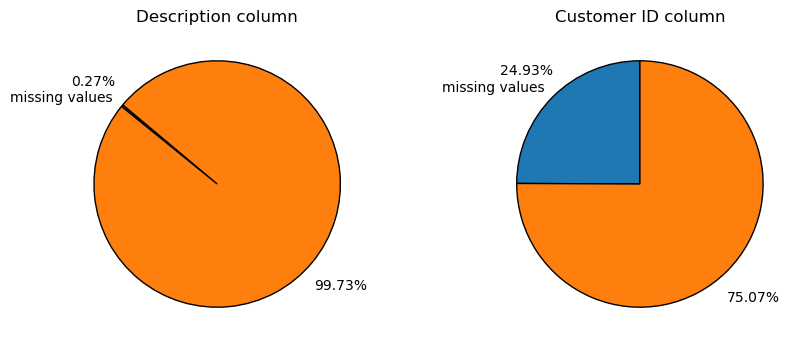

In [67]:
sizes_descr = [pct_missing_descr, 100 - pct_missing_descr]
sizes_id = [pct_missing_id, 100 - pct_missing_id]
labels = ["missing values", ""]

fig, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].pie(sizes_descr, labels = labels, autopct = "%1.2f%%", startangle = 140, pctdistance = 1.3, wedgeprops = {'edgecolor': 'black'})
axes[0].set_title("Description column")

axes[1].pie(sizes_id, labels = labels, autopct = "%1.2f%%", startangle = 90, pctdistance = 1.3, wedgeprops = {'edgecolor': 'black'})
axes[1].set_title("Customer ID column")

plt.show()

In [68]:
data = data.dropna(subset = ["description", "customer_id"])

In [69]:
data.shape

(406829, 8)

Find duplicates if there are any and remove them, because I think they are errors. It cannot has exactly the same transactions, at the same time, made by the same client.

In [70]:
data[data.duplicated()]

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [71]:
data = data.drop_duplicates(ignore_index = True)

In [72]:
data[data.duplicated()]

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country


In [74]:
data.invoice_no.value_counts()

invoice_no
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C560912      1
560913       1
560917       1
572879       1
553049       1
Name: count, Length: 22190, dtype: int64

In [75]:
c_invoices = data[data.invoice_no.str.startswith("C")]
c_invoices

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
401159,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
401243,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
401410,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
401411,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [76]:
all(c_invoices[c_invoices.quantity < 0])

True

The invoice values starts with 'C' have negative quantity value, so they are likely cancelled. But I will not remove them. I will make new binary column: whether the transaction is successfully completed of cancelled. This new column will help for better segmentation and will facilitate clustering algorithms.

In [77]:
data["tr_status"] = data.quantity.apply(lambda x: 0 if x < 0 else 1)

In [82]:
data.sample(5)

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,tr_status
287504,570672,21866,UNION JACK FLAG LUGGAGE TAG,12,2011-10-11 14:52:00,1.25,12536.0,France,1
218379,563697,23203,JUMBO BAG VINTAGE DOILY,3,2011-08-18 13:44:00,2.08,16813.0,United Kingdom,1
344004,575972,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,4,2011-11-13 13:01:00,2.95,14499.0,United Kingdom,1
225483,564436,23201,JUMBO BAG ALPHABET,2,2011-08-25 12:06:00,2.08,17841.0,United Kingdom,1
291226,C571066,21238,RED RETROSPOT CUP,-1,2011-10-13 15:05:00,0.85,12709.0,Germany,0


In [85]:
cancelled_trs_count = len(data[data.tr_status == 0])
print(f"{(cancelled_trs_count / len(data)) * 100:.2f}% or {cancelled_trs_count} transactions are cancelled.")

2.21% or 8872 transactions are cancelled.


In [86]:
data.stockcode.value_counts()

stockcode
85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
          ... 
90104        1
90135        1
90027D       1
90027A       1
84746        1
Name: count, Length: 3684, dtype: int64

In [87]:
unique_codes = data.stockcode.unique()

In [89]:
print(f"There are {len(unique_codes)} unique products (stockcodes).")

There are 3684 unique products (stockcodes).


There are values with letters in the stockcode, so i will do a more detailed analysis of them:

In [90]:
stockcode_with_chars = pd.DataFrame([code for code in unique_codes if not(code.isnumeric())])
print(f"There are {len(stockcode_with_chars)} unique stockcodes containing character/s.")

There are 886 unique stockcodes containing character/s.


In [91]:
stockcode_chars_nums = pd.Series(["".join(el for el in code if el.isalpha()) for code in unique_codes if not(code.isnumeric())])
stockcode_chars_nums.value_counts()

B              260
A              235
C              137
D               80
E               32
F               23
P               18
G               16
S               14
L               14
M               10
J                6
K                5
N                5
W                4
V                4
U                4
H                4
R                3
T                2
BL               1
BANKCHARGES      1
POST             1
PADS             1
Y                1
I                1
DOT              1
CRUK             1
O                1
Z                1
Name: count, dtype: int64

I want to find where and how many times each letter occurs among all the unique codes:

In [92]:
char_to_stockcodes = defaultdict(set)

for code in data.stockcode:
    for char in set(code): # ensures each char is counted once per stockcode (avoids duplicate letters)
        if char.isalpha(): 
            char_to_stockcodes[char].add(code)


char_stock_df = pd.DataFrame({"character": list(char_to_stockcodes.keys()), 
                              "codes": [", ".join(sorted(stockcodes)) for stockcodes in char_to_stockcodes.values()],
                             })

char_stock_df["counts_codes_containing_char"] = char_stock_df.codes.apply(lambda x: len(x.split(", ")))
char_stock_df

,character,codes,counts_codes_containing_char
0,A,"10124A, 15044A, 15058A, 16151A, 16202A, 16207A...",237
1,B,"15044B, 15056BL, 15058B, 15060B, 16202B, 16206...",262
2,G,"10124G, 16161G, 35001G, 35004G, 47021G, 72801G...",17
3,E,"16169E, 16202E, 17012E, 37462E, 46776E, 71101E...",33
4,P,"15056P, 16161P, 16169P, 17084P, 35004P, 35815P...",20
5,S,"16156S, 35271S, 46000S, 72051S, 82001S, 84760S...",17
6,T,"35591T, 90214T, DOT, POST",4
7,O,"90214O, DOT, POST",3
8,L,"15056BL, 16156L, 16162L, 51014L, 75049L, 82494...",15
9,C,"10123C, 15044C, 15058C, 16020C, 17012C, 18094C...",139


Check stockcodes that contains 2 or more letters:

In [99]:
filtered_stockcodes = data[data.stockcode.str.count(r'[A-Za-z]') >= 3]
filtered_stockcodes.stockcode.value_counts()

stockcode
POST            1196
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

Check short stockcodes:

In [100]:
small_stockcodes = data[data.stockcode.str.len() <= 3]
small_stockcodes.stockcode.value_counts()

stockcode
M      460
C2     134
D       77
DOT     16
Name: count, dtype: int64

I can conclude that stockcodes: POST, BANK CHARGES, PADS, DOT, CRUK, M, C2, D are anomalies. They may be services, fees or other product-related transactions, but they aren't actual product transaction. 

In [102]:
anomalies = ["POST", "BANK CHARGES", "PADS", "DOT", "CRUK", "M", "C2", "D"]

In [103]:
anomalies_stockcodes = data[data.stockcode.isin(anomalies)]
len(anomalies_stockcodes)

1915

In [104]:
anomalies_stockcodes.description.unique()

array(['POSTAGE', 'Discount', 'CARRIAGE', 'Manual', 'Bank Charges',
       'PADS TO MATCH ALL CUSHIONS', 'DOTCOM POSTAGE', 'CRUK Commission'],
      dtype=object)

So i remove the anomalies:

In [105]:
data = data[~data.stockcode.isin(anomalies)]

In [106]:
data.shape

(399689, 9)

Continue with description column:

In [107]:
data.description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [108]:
len(data.description.unique())

3888

I remove spaces before and after text in description column to standartize the data:

In [111]:
data.description = data.description.str.strip()

In [112]:
len(data.description.unique())

3877

Check descriptions, containing lower case letters:

In [113]:
lowercase_descr = [d for d in data.description.unique() if any(char.islower() for char in d)]
lowercase_descr

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

'Next Day Carriage' and 'High Resolution Image' arent actual descriptions of the product, so i remove them:

In [115]:
len(data[data.description.isin(['Next Day Carriage', 'High Resolution Image'])])

83

In [116]:
data = data[~data.description.isin(['Next Day Carriage', 'High Resolution Image'])]

Standartize other lower case description - make them uppercase:

In [117]:
data.description = data.description.str.upper()

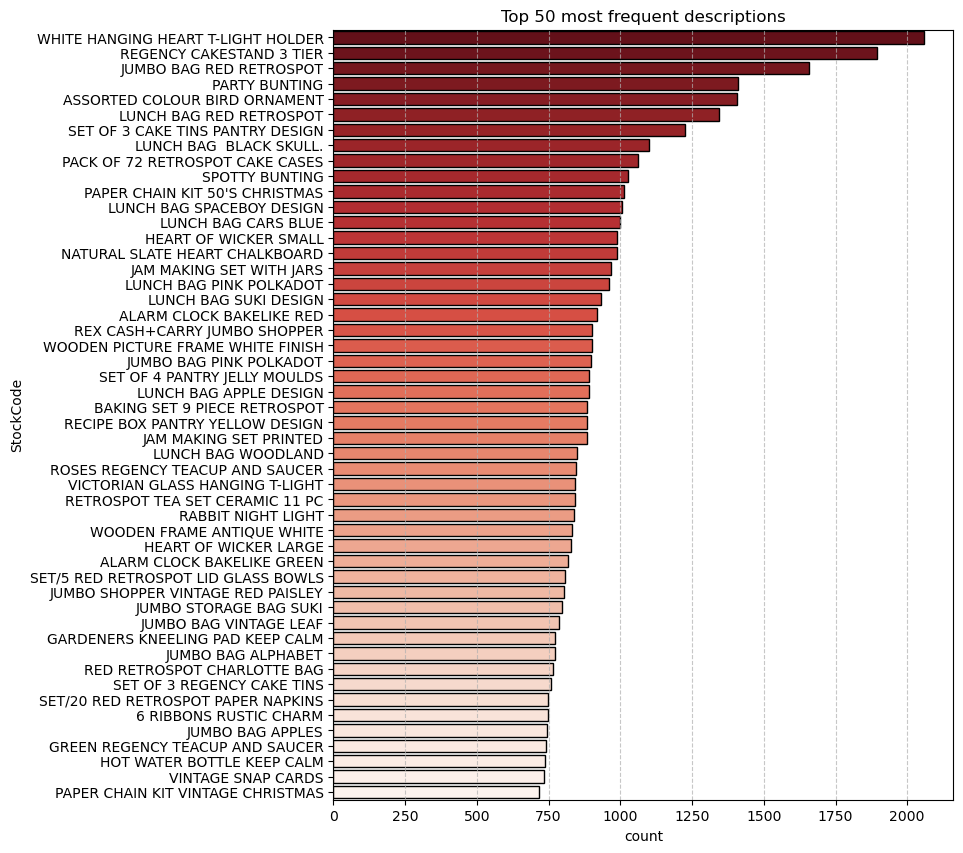

In [118]:
top_descriptions = data.description.value_counts()[:50]

plt.figure(figsize = (8, 10))
sns.barplot(
    y = top_descriptions.index,
    x = top_descriptions.values,
    palette = "Reds_r",  
    hue = top_descriptions.index, 
    edgecolor = "black")

plt.xlabel("count")
plt.ylabel("StockCode")
plt.title(f"Top 50 most frequent descriptions")
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)
plt.show()

Continue with quantity column:

In [119]:
data.quantity.value_counts()

quantity
 1        68873
 12       59813
 2        57098
 6        37423
 4        31980
          ...  
 828          1
 560          1
-408          1
 512          1
-80995        1
Name: count, Length: 432, dtype: int64

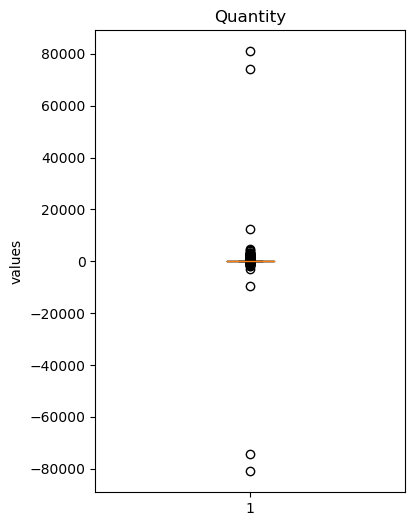

In [121]:
plt.figure(figsize = (4, 6))

plt.boxplot(data.quantity)
plt.ylabel("values")
plt.title("Quantity")
plt.show()

Invoice date and time column:

In [122]:
data.invoice_date

0         2010-12-01 08:26:00
1         2010-12-01 08:26:00
2         2010-12-01 08:26:00
3         2010-12-01 08:26:00
4         2010-12-01 08:26:00
                 ...         
401599    2011-12-09 12:50:00
401600    2011-12-09 12:50:00
401601    2011-12-09 12:50:00
401602    2011-12-09 12:50:00
401603    2011-12-09 12:50:00
Name: invoice_date, Length: 399606, dtype: object

Convert it to datetime64:

In [123]:
data.invoice_date = pd.to_datetime(data.invoice_date)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399606 entries, 0 to 401603
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    399606 non-null  object        
 1   stockcode     399606 non-null  object        
 2   description   399606 non-null  object        
 3   quantity      399606 non-null  int64         
 4   invoice_date  399606 non-null  datetime64[ns]
 5   unit_price    399606 non-null  float64       
 6   customer_id   399606 non-null  float64       
 7   country       399606 non-null  object        
 8   tr_status     399606 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.5+ MB


Check unit_price column:

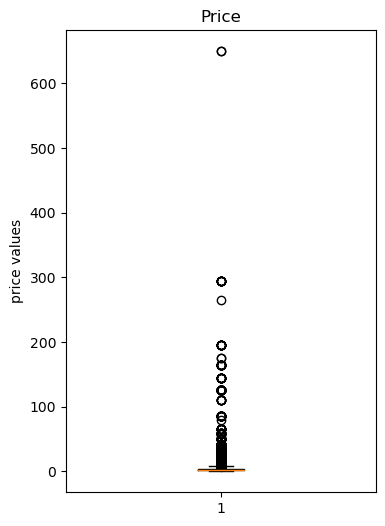

In [127]:
plt.figure(figsize = (4, 6))

plt.boxplot(data.unit_price)
plt.ylabel("price values")
plt.title("Price")
plt.show()

In [128]:
max_price_records = data[data.unit_price == data.unit_price.max()]
max_price_records

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,tr_status
157405,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,1
157407,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,1


In [129]:
min_price_records = data[data.unit_price == data.unit_price.min()]
min_price_records

,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,tr_status
6842,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,1
22619,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,1
25551,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,1
29374,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,1
29376,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,1
34903,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,1
54482,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,1
86760,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,1
93947,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,1
98634,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,1


In [130]:
print(f"There are {len(min_price_records)} products with 0 price.")

There are 33 products with 0 price.


From the information below, we can see that 60 products are free. The important thing is that the real price of these product isnt zero. Maybe they are gifts. I think they may negatively affect clustering, so I will remove them:

In [131]:
data = data[data.unit_price > 0]

Continue with customer ID:

In [132]:
print(f"There are {len(data.customer_id.unique())} customers in this dataset.")

There are 4362 customers in this dataset.


In [133]:
top_customers = data.customer_id.value_counts()
top_customers

customer_id
17841.0    7800
14911.0    5806
14096.0    5095
12748.0    4440
14606.0    2755
           ... 
17948.0       1
17382.0       1
14351.0       1
16995.0       1
16148.0       1
Name: count, Length: 4362, dtype: int64

I check the number of distinct products bought by a customer:

In [134]:
unique_products_by_customer = data.groupby("customer_id")["stockcode"].nunique().reset_index()
unique_products_by_customer.rename(columns = {"stockcode": "count_unique_products"}, inplace = True)
unique_products_by_customer

,customer_id,count_unique_products
0,12346.0,1
1,12347.0,103
2,12348.0,21
3,12349.0,72
4,12350.0,16
...,...,...
4357,18280.0,10
4358,18281.0,7
4359,18282.0,12
4360,18283.0,262


There are customers who have many purchases. But there are customers that have only one purchase. Based on this information i will make new product feature for better grouping.

Country column:

In [135]:
print(f"There are {len(data.country.unique())} unique countries in this dataset.")

There are 37 unique countries in this dataset.


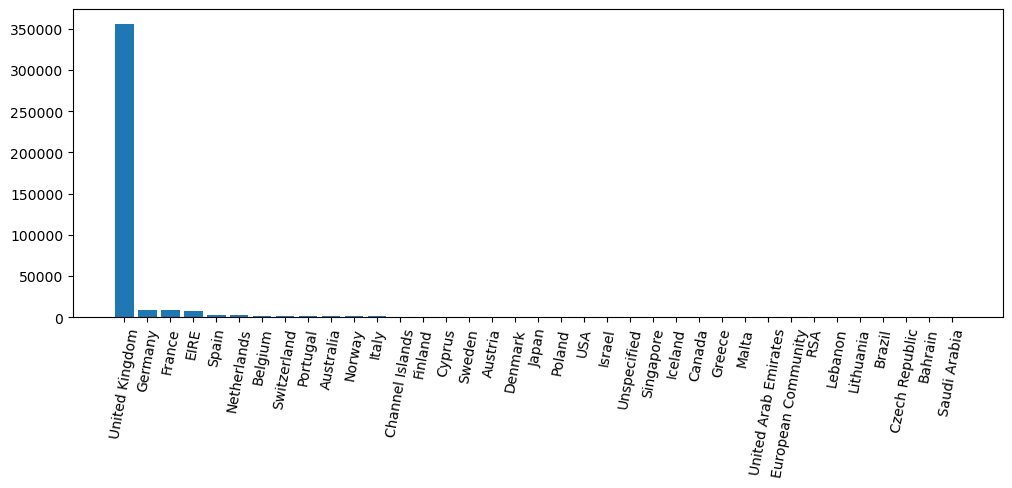

In [138]:
ordered_countries = pd.DataFrame(data.country.value_counts()).reset_index()

plt.figure(figsize = (12, 4))
plt.bar(ordered_countries.country, ordered_countries["count"])
plt.xticks(rotation = 80)
plt.show()

In [139]:
top_country_pct = len(data[data.country == "United Kingdom"]) / len(data) * 100
print(f"{top_country_pct:.2f} of purchases are from United Kingdom.")

89.10 of purchases are from United Kingdom.


## Feature engineering

I will create new columns for Recency, Frequency Monetary and other to extract important information and trends. 

### Recency
Recency is the metric that indicates how recently a customer has made a purchase. If the recency value is lower means the customer has purchased soon (few day ago for example). This indicates higher engagement. If the recency value is high means the customer has purchased a long time ago (for example last year). \
To compute Recency i must find how many days ago the customer made their last purchase:

In [140]:
# get the most recent date in the dataset:
reference_date = data.invoice_date.max()

# To compute Recency I group by 'customer_id' and find the most recent purchase date for each customer.
# Then, I subtract it from the reference_date to get the number of days since the last purchase.
recency = data.groupby("customer_id")["invoice_date"].max().reset_index()
recency["recency"] = (reference_date - recency["invoice_date"]).dt.days  # days since last purchase
recency.drop(columns = ["invoice_date"], inplace = True)

# recency shows the days since last purchase:
recency.head()

,customer_id,recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


### Frequency
Frequency shows how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the store more often. This suggests higher satisfaction. \
Frequency measures how many unique purchases (invoices) a customer has made.

In [141]:
# to compute frequency I group by 'customer_id' and count the number of unique 'invoice' entries for each customer:
frequency = data.groupby("customer_id")["invoice_no"].nunique().reset_index()
frequency.rename(columns = {"invoice_no": "frequency"}, inplace = True)
frequency.head()

,customer_id,frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


### Monetary
Monetary measures the total amount of money a customer has spent over a certain period. A higher monetary value means the customer is a high spender, contributing more to the business. A lower monetary value means the customer has spent less overall. To compute monetary i calculate total amount spent per purchase (Quantity * Price). Then I sum up this total amount for each customer:

In [144]:
# compute monetary: total amount of spent transactions = quantity * unit_price:
data["total_spent"] = data["quantity"] * data["unit_price"]

# group by 'customer_id' and sum 'total_spent' to get the total amount spent per customer:
monetary = data.groupby("customer_id")["total_spent"].sum().reset_index()
monetary.rename(columns = {"total_spent": "monetary"}, inplace = True) 
monetary.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_8536\2818724550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["total_spent"] = data["quantity"] * data["unit_price"]


,customer_id,monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


### Average Transaction Value
ATV represents how much a customer spends on average per transaction. It is calculated as total_spend divided by the number of transactions (invoices) per customer.

In [145]:
# find total spend per customer
total_spend = data.groupby("customer_id", as_index = False).agg({"total_spent": "sum"})

# compute total transactions per customer
total_transactions = data.groupby("customer_id", as_index = False).agg({"invoice_no": "nunique"})
total_transactions.rename(columns={"invoice_no": "total_transactions"}, inplace = True)

# compute ATV:
average_transaction_value = total_spend.merge(total_transactions, on = "customer_id")
average_transaction_value["average_transaction_value"] = (
    average_transaction_value["total_spent"] / average_transaction_value["total_transactions"])

ATV_data = total_spend.merge(average_transaction_value[["customer_id", "average_transaction_value"]], on = "customer_id")
ATV_data

,customer_id,total_spent,average_transaction_value
0,12346.0,0.00,0.000000
1,12347.0,4310.00,615.714286
2,12348.0,1437.24,359.310000
3,12349.0,1457.55,1457.550000
4,12350.0,294.40,294.400000
...,...,...,...
4357,18280.0,180.60,180.600000
4358,18281.0,80.82,80.820000
4359,18282.0,176.60,58.866667
4360,18283.0,2039.58,127.473750


### Country feature
Based on information about countries: 89.99 of purchases are from United Kingdom, i make a new binary feature containig whether the transaction is from UK (1) or from somewhere else (0):

In [146]:
customer_location = data[["customer_id", "country"]].drop_duplicates()
customer_location["is_from_uk"] = customer_location["country"].apply(lambda x: 1 if x == "United Kingdom" else 0)
customer_location = customer_location.drop(columns = ["country"])
customer_location.is_from_uk.value_counts()

is_from_uk
1    3942
0     428
Name: count, dtype: int64

### Datetime features: 
I find the day and the hour a customer orders most often - favorite day and hour for shopping:

In [147]:
data.invoice_date.dt.month.value_counts()

invoice_date
11    63911
10    49699
12    43535
9     40258
5     28511
6     27439
3     27358
8     27287
7     27099
4     22874
1     21562
2     20040
Name: count, dtype: int64

In [148]:
# extract the day and the hour of the week:
data["shopping_day"] = data["invoice_date"].dt.dayofweek

# compute the most frequent shopping day per customer using mode:
top_shopping_day = data.groupby("customer_id")["shopping_day"].agg(lambda x: x.mode()[0]).reset_index()
top_shopping_day.rename(columns = {"shopping_day": "favorite_shopping_day"}, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_8536\1296861485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["shopping_day"] = data["invoice_date"].dt.dayofweek


I find average monthly amount a customer spends. This feature shows spending behaviour of each customer. This metric helps identify high spenders and budget-conscious customers. A higher value indicates a customer who spends more, potentially showing interest in expensive, high quality products. A lower value might indicate a more budget-conscious customer.

In [150]:
# extract year-month:
data["year_month"] = data["invoice_date"].dt.to_period("M")

# compute total monthly spending per customer
monthly_spending = data.groupby(["customer_id", "year_month"])["total_spent"].sum().reset_index()

# Step 4: Compute the Monthly Spending Mean per Customer
monthly_spending_mean = monthly_spending.groupby("customer_id")["total_spent"].mean().reset_index()
monthly_spending_mean.rename(columns = {"total_spent": "monthly_spending_mean"}, inplace = True)
monthly_spending_mean

C:\Users\USER\AppData\Local\Temp\ipykernel_8536\2311985948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["year_month"] = data["invoice_date"].dt.to_period("M")


,customer_id,monthly_spending_mean
0,12346.0,0.000000
1,12347.0,615.714286
2,12348.0,359.310000
3,12349.0,1457.550000
4,12350.0,294.400000
...,...,...
4357,18280.0,180.600000
4358,18281.0,80.820000
4359,18282.0,88.300000
4360,18283.0,203.958000


### Trends in purchases
Make new features based on cancellation purchases:
- Cancellation Frequency: Total number of transactions a customer has cancelled.
- Cancellation Rate: Proportion of canceled transactions relative to all transactions.

In [151]:
# Identify cancelled transactions - if quantity < 0:
data["is_cancelled"] = data["quantity"].apply(lambda x: 1 if x < 0 else 0)

# compute cancellation frequency per customer - count the number of cancelled transactions / customer:
cancellation_frequency = data.groupby("customer_id")['is_cancelled'].sum().reset_index()
cancellation_frequency.rename(columns = {"is_cancelled": "cancellation_frequency"}, inplace = True)

# compute total transactions per customer - count the total number of transactions for each customer
total_transactions = data.groupby("customer_id")["invoice_no"].nunique().reset_index()
total_transactions.rename(columns = {"invoice_no": "total_transactions"}, inplace = True)

# cancellation rate = cancelled transactions / total transactions
cancellation_data = cancellation_frequency.merge(total_transactions, on = "customer_id")
cancellation_data["cancellation_rate"] = (cancellation_data["cancellation_frequency"] / cancellation_data["total_transactions"]).round(2)
cancellation_data = cancellation_data.drop(columns = ["total_transactions"])
cancellation_data

C:\Users\USER\AppData\Local\Temp\ipykernel_8536\465218898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_cancelled"] = data["quantity"].apply(lambda x: 1 if x < 0 else 0)


,customer_id,cancellation_frequency,cancellation_rate
0,12346.0,1,0.50
1,12347.0,0,0.00
2,12348.0,0,0.00
3,12349.0,0,0.00
4,12350.0,0,0.00
...,...,...,...
4357,18280.0,0,0.00
4358,18281.0,0,0.00
4359,18282.0,1,0.33
4360,18283.0,0,0.00


### Overview of extracted customer information
First i merge all dataframes into one:

In [160]:
dfs = [unique_products_by_customer, 
       recency, 
       frequency, 
       monetary,
       ATV_data, 
       customer_location,
       top_shopping_day,
       monthly_spending_mean, 
       cancellation_data]

In [161]:
for i, df in enumerate(dfs):
    print(f"{i}: {df.columns}")

0: Index(['customer_id', 'count_unique_products'], dtype='object')
1: Index(['customer_id', 'recency'], dtype='object')
2: Index(['customer_id', 'frequency'], dtype='object')
3: Index(['customer_id', 'monetary'], dtype='object')
4: Index(['customer_id', 'average_transaction_value'], dtype='object')
5: Index(['customer_id', 'is_from_uk'], dtype='object')
6: Index(['customer_id', 'favorite_shopping_day'], dtype='object')
7: Index(['customer_id', 'monthly_spending_mean'], dtype='object')
8: Index(['customer_id', 'cancellation_frequency', 'cancellation_rate'], dtype='object')


In [162]:
ATV_data = ATV_data[["customer_id", "average_transaction_value"]]

In [163]:
cleaned_dfs = [unique_products_by_customer, 
               recency, 
               frequency, 
               monetary,
               ATV_data, 
               customer_location,
               top_shopping_day,
               monthly_spending_mean, 
               cancellation_data]

Reduce applies the merging function iteratively to all dataframes in the dfs list. In each iteration I merge two dataframes (left and right) at a time, based on the customer_id column.

In [164]:
extracted_customer_data = reduce(lambda left, right: pd.merge(left, right, on = "customer_id"), cleaned_dfs)

In [165]:
extracted_customer_data

,customer_id,count_unique_products,recency,frequency,monetary,average_transaction_value,is_from_uk,favorite_shopping_day,monthly_spending_mean,cancellation_frequency,cancellation_rate
0,12346.0,1,325,2,0.00,0.000000,1,1,0.000000,1,0.50
1,12347.0,103,1,7,4310.00,615.714286,0,1,615.714286,0,0.00
2,12348.0,21,74,4,1437.24,359.310000,0,3,359.310000,0,0.00
3,12349.0,72,18,1,1457.55,1457.550000,0,0,1457.550000,0,0.00
4,12350.0,16,309,1,294.40,294.400000,0,2,294.400000,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
4365,18280.0,10,277,1,180.60,180.600000,1,0,180.600000,0,0.00
4366,18281.0,7,180,1,80.82,80.820000,1,6,80.820000,0,0.00
4367,18282.0,12,7,3,176.60,58.866667,1,4,88.300000,1,0.33
4368,18283.0,262,3,16,2039.58,127.473750,1,3,203.958000,0,0.00


In [166]:
extracted_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                4370 non-null   float64
 1   count_unique_products      4370 non-null   int64  
 2   recency                    4370 non-null   int64  
 3   frequency                  4370 non-null   int64  
 4   monetary                   4370 non-null   float64
 5   average_transaction_value  4370 non-null   float64
 6   is_from_uk                 4370 non-null   int64  
 7   favorite_shopping_day      4370 non-null   int32  
 8   monthly_spending_mean      4370 non-null   float64
 9   cancellation_frequency     4370 non-null   int64  
 10  cancellation_rate          4370 non-null   float64
dtypes: float64(5), int32(1), int64(5)
memory usage: 358.6 KB


In [159]:
extracted_customer_data.customer_id = extracted_customer_data.customer_id.astype(str)

#### Merged Dataframe:
- customer_id - Unique identifier for each customer.
- count_unique_products - The total number of distinct products purchased by the customer. A higher count suggests a diverse shopping preference.
- recency - Number of days since the last purchase. Lower values indicate recent activity, while higher values suggest inactivity.
- frequency - Total number of purchases (invoices) made by the customer. A higher value indicates frequent engagement.
- monetary - Total amount of money spent by the customer. Represents the overall revenue contribution of the customer.
- average_transaction_value - Average amount spent per purchase. It helps understand whether the customer makes large or small transactions.
- is_from_uk - Binary indicator: 1 - the customer is from UK, 0 - the customer isnt from UK.
- top_shopping_day - day from 0 to 6 indicating the favorite shopping day - when a customer shop most frequent.
- monthly_spending_mean - Average amount spent per month. Identifies customers with consistent spending habits.
- cancellation_frequency - Total number of transactions canceled by the customer. A higher count suggests potential dissatisfaction or purchase indecisiveness.
- cancellation_rate - Proportion of canceled transactions out of total transactions. A higher value indicates a greater tendency to cancel purchases.

### Detecting Customer Outliers
Customer outliers are points that are significantly different from the majority of other points in the dataset. It is important to identify these abomalies, because they will affect clustering and skew the results. The best approach to for detecting customer outliers is to use unsupervised anomaly detection algorithms: Isolation Forest, DBSCAN, One-Class SVM. I prefer **Isolation Forest** because it is fast even for large datasets (One-Class SVM can be slow on large data), works well for high-dimensional data. It uses decision trees to isolate anomalies.

In [167]:
features = extracted_customer_data.drop(columns = ["customer_id"])

# isolation forest with contamination ~ 5% anomalies
IF_model = IsolationForest(n_estimators = 100, contamination = 0.05, random_state = 42)
extracted_customer_data["anomaly_score"] = IF_model.fit_predict(features)

# label outliers with -1 = outlier, 1 = normal:
extracted_customer_data["is_outlier"] = extracted_customer_data["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

In [168]:
extracted_customer_data.is_outlier.value_counts()

is_outlier
0    4151
1     219
Name: count, dtype: int64

The anomalies are relatively small amount (219) and I will remove them:

In [169]:
clean_data = extracted_customer_data[extracted_customer_data.is_outlier == 0]

clean_data = clean_data.drop(columns = ["anomaly_score", "is_outlier"])
clean_data.reset_index(drop = True, inplace = True)

In [170]:
clean_data.shape

(4151, 11)

In [171]:
clean_data.head()

,customer_id,count_unique_products,recency,frequency,monetary,average_transaction_value,is_from_uk,favorite_shopping_day,monthly_spending_mean,cancellation_frequency,cancellation_rate
0,12346.0,1,325,2,0.00,0.000000,1,1,0.000000,1,0.5
1,12347.0,103,1,7,4310.00,615.714286,0,1,615.714286,0,0.0
2,12348.0,21,74,4,1437.24,359.310000,0,3,359.310000,0,0.0
3,12349.0,72,18,1,1457.55,1457.550000,0,0,1457.550000,0,0.0
4,12350.0,16,309,1,294.40,294.400000,0,2,294.400000,0,0.0


### Correlation analysis

In [172]:
corr = clean_data.drop(columns = ["customer_id"]).corr()

In [173]:
corr

,count_unique_products,recency,frequency,monetary,average_transaction_value,is_from_uk,favorite_shopping_day,monthly_spending_mean,cancellation_frequency,cancellation_rate
count_unique_products,1.000000,-0.347918,0.569749,0.583114,0.197085,0.043832,0.076948,0.330290,0.293442,0.080512
recency,-0.347918,1.000000,-0.372138,-0.344620,-0.091700,-0.000284,-0.012209,-0.167310,-0.186394,-0.049916
frequency,0.569749,-0.372138,1.000000,0.802147,-0.030518,0.031035,0.011647,0.215727,0.581246,0.193745
monetary,0.583114,-0.344620,0.802147,1.000000,0.377101,-0.002857,0.000689,0.579636,0.420388,0.103964
average_transaction_value,0.197085,-0.091700,-0.030518,0.377101,1.000000,-0.101861,-0.033988,0.878399,-0.080167,-0.127779
is_from_uk,0.043832,-0.000284,0.031035,-0.002857,-0.101861,1.000000,0.043695,-0.058593,0.020011,0.012866
favorite_shopping_day,0.076948,-0.012209,0.011647,0.000689,-0.033988,0.043695,1.000000,-0.018820,-0.024541,-0.038312
monthly_spending_mean,0.330290,-0.167310,0.215727,0.579636,0.878399,-0.058593,-0.018820,1.000000,0.108324,0.007587
cancellation_frequency,0.293442,-0.186394,0.581246,0.420388,-0.080167,0.020011,-0.024541,0.108324,1.000000,0.711884
cancellation_rate,0.080512,-0.049916,0.193745,0.103964,-0.127779,0.012866,-0.038312,0.007587,0.711884,1.000000


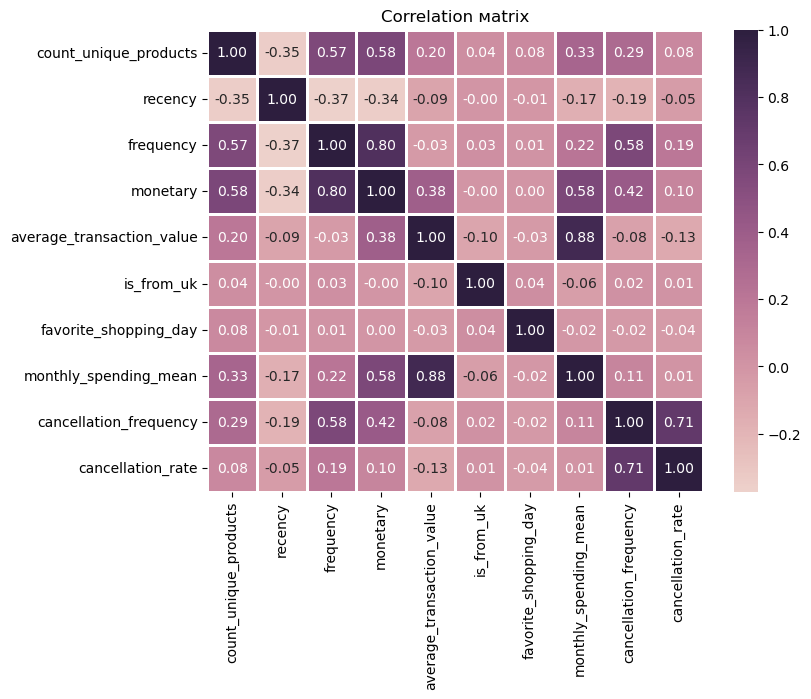

In [174]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr, cmap = sns.cubehelix_palette(as_cmap = True), annot = True, fmt = ".2f", linewidths = 1)
plt.title("Correlation мatrix")
plt.show()

There are strong positive relashionship between:
- average_transaction_value and monthly_spending_mean (0,88) - customers with higher average transaction values tend to spend more per month.
- frequency and monetary (0,80) - customers who purchase more frequently naturally tend to spend more money overall.
- cancellation_frequency and cancellation_rate are also correlated (0,71) which is normal.

As we can see **multicollinearity** occurs - two or more features are highly correlated (above 0,70). This means that the features provide redundant information. It can distort model performance in clustering algorithms because highly correlated variables can overpower the importance of other features. Maybe data standartization and techniques for dimensionality reduction (PCA), can help.  

### Standardize the data
I Standardize the data to reduce impact of features with large values. This is very important in the context of distance-based algorithms (PCA and K-means). I scale all features excluding customer_id, is_from_uk (it is in standard binary format).

In [175]:
# select only columns that need scaling:
cols_to_scale = ['count_unique_products', 'recency', 'frequency', 'monetary', 'average_transaction_value',
            'monthly_spending_mean', 'cancellation_frequency', 'cancellation_rate']

In [176]:
scaler = StandardScaler()
clean_data[cols_to_scale] = scaler.fit_transform(clean_data[cols_to_scale])

In [177]:
clean_data.head()

,customer_id,count_unique_products,recency,frequency,monetary,average_transaction_value,is_from_uk,favorite_shopping_day,monthly_spending_mean,cancellation_frequency,cancellation_rate
0,12346.0,-0.890013,2.321680,-0.467675,-0.775701,-1.341884,1,1,-1.326326,-0.064922,0.705186
1,12347.0,0.808674,-0.909848,0.636728,2.148732,1.559335,0,1,0.976963,-0.423290,-0.449001
2,12348.0,-0.556937,-0.181757,-0.025914,0.199499,0.351169,0,3,0.017796,-0.423290,-0.449001
3,12349.0,0.292406,-0.740292,-0.688556,0.213280,5.526028,0,0,4.126137,-0.423290,-0.449001
4,12350.0,-0.640206,2.162099,-0.688556,-0.575944,0.045316,0,2,-0.225022,-0.423290,-0.449001


### Principal Component Analysis
PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while retaining as much information / variance as possible. PCA can transform correlated variables into uncorrelated principal components. These new features maximize the variance.

I use one-hot encoding (pd.get_dummies) to correctly represent categorical data - each weekday is treated as an independent category. PCA sees each day as equally distant and not numerically ordered.

In [199]:
clean_data.set_index("customer_id", inplace = True)

In [200]:
# apply PCA, keeping all components initially:
n = len(clean_data.columns)
pca = PCA(n_components = n)  
principal_components = pca.fit_transform(clean_data)

In [203]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.90
opt_pc_count = np.argmax(cumulative_variance >= threshold) + 1 

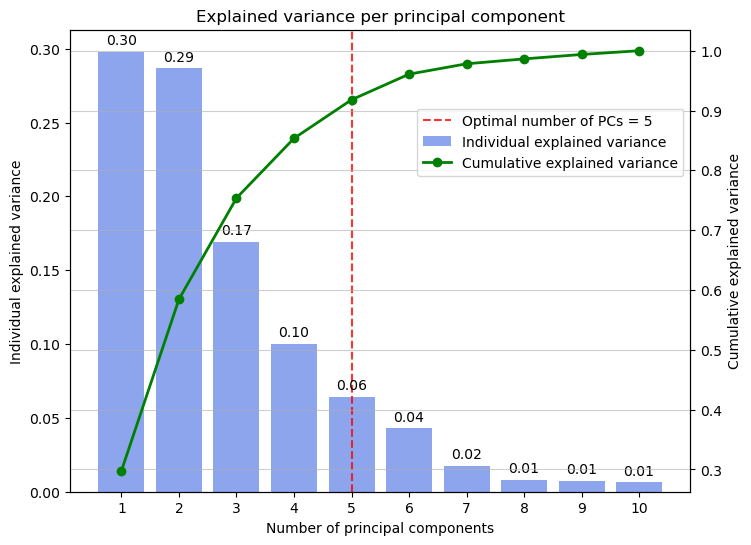

In [204]:
fig, ax1 = plt.subplots(figsize = (8, 6))
bars = ax1.bar(range(1, len(explained_variance) + 1),
               explained_variance, 
               alpha = 0.6, 
               align = "center", 
               label = "Individual explained variance", 
               color = "royalblue")

ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance,
         linewidth = 2, 
         marker = "o", 
         label = "Cumulative explained variance",
         color = "green")

ax1.axvline(x = optimal_pc_count, color = "red", linestyle = "--", alpha = 0.8, label = f"Optimal number of PCs = {opt_pc_count}")

for bar, var in zip(bars, explained_variance):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{var:.2f}", ha = "center")

ax1.set_xlabel("Number of principal components")
ax1.set_ylabel("Individual explained variance")
ax2.set_ylabel("Cumulative explained variance")
ax1.set_title("Explained variance per principal component")
ax2.grid(axis = "y", alpha = 0.6)
plt.xticks(range(1, len(cumulative_variance) + 1))
fig.legend(loc = "upper right", bbox_to_anchor = (0.9, 0.76))
plt.show()

🔵 Blue bars show the variance explained by each individual principal component. \
🔴 Red dashed line shows the cumulative variance explained as more components are added. \
Numbers above bars indicate the exact variance explained by each component. 

We can see that the first two components explain 59% of the variance in the data. First few 5 components explain 92% of the variance, so I will reduce dimensions to just those components, because i think it's enough, instead of using all features. 

I take a look at the point where the cumulative variance curve starts to flatten (elbow point) - where variance gain slows down.

In [205]:
pca = PCA(n_components = opt_pc_count)
pca_customer_data = pca.fit_transform(clean_data)
pca_customer_df = pd.DataFrame(pca_customer_data, columns = ["PC" + str(i+1) for i in range(pca.n_components_)])

# adding the customer_id index back to the new PCA df:
pca_customer_df.index = clean_data.index
pca_customer_df.head()

,PC1,PC2,PC3,PC4,PC5
customer_id,,,,,
12346.0,-1.884465,-2.007320,-1.568231,0.847279,1.592493
12347.0,-1.172422,2.600162,1.738529,-0.670459,-0.014799
12348.0,0.394864,-0.277662,0.624828,-0.168607,-0.150070
12349.0,-2.338541,2.999908,5.635065,2.388419,-1.495536
12350.0,-0.831718,-1.624390,0.496932,0.858130,1.513973


In [206]:
actual_features_used = clean_data.columns.tolist()

loadings_df = pd.DataFrame(
    pca.components_.T,
    index = actual_features_used,
    columns = [f'PC{i+1}' for i in range(pca.n_components_)]
)

loadings_df

,PC1,PC2,PC3,PC4,PC5
count_unique_products,0.107289,0.386272,0.006659,-0.281414,0.163666
recency,-0.050321,-0.268787,0.031400,0.418235,0.858945
frequency,0.073864,0.440528,-0.223093,-0.272612,0.297753
monetary,0.070689,0.490076,0.072933,-0.110466,0.261921
average_transaction_value,0.005695,0.234982,0.571318,0.334683,-0.126146
is_from_uk,0.007017,-0.001530,-0.015930,-0.014080,0.011158
favorite_shopping_day,0.986748,-0.144124,0.003555,0.063539,-0.014356
monthly_spending_mean,0.030695,0.349570,0.469158,0.318669,-0.049001
cancellation_frequency,0.027465,0.338970,-0.443078,0.332839,-0.012104
cancellation_rate,-0.007379,0.176687,-0.448088,0.575140,-0.243674


Each value in the table shows how much a feature contributes to a principal component (column).
High absolute values (+/- 0.4 or more) mean that feature strongly influences that component. The sign (+/-) indicates direction, not importance. The principal components (PC1-PC5) are new latent features that combine the original features into fewer dimensions, preserving variance.

- PC1 is dominated by the customer’s favorite shopping day. This component reflects time-of-week shopping behavior, not spending or loyalty.
- PC2 represents active spending and engaged customers. High values shows frequent, high-spending, multi-product, stable shoppers. Low values - inactive or less engaged.
- PC3 contrasts high-spending customers (positive side) with customers who cancel a lot (negative side). 
- PC4 highlights inactive customers who also cancel often. This is a good indicator of at-risk or dissatisfied customers.
- PC5 is strongly driven by recency alone (inactivity), with some influence from how often and diversely the customer shops.

## Clustering 

### K-Means
K-Means is an unsupervised ML algorithm used to group similar data points into clusters. Each cluster has a centroid - this is a mean of a cluster. The sum of squared distances between each point and its assigned centroid is Inertia. The goal is minimizing inertia - each point is close to its cluster center and clusters are distinct from one another. Within-Cluster Sum of Squares (WCSS) / inertia measures how tightly grouped each cluster is. Inter-cluster distances used in silhouette is the distance between cluster centers. How it works: First choosing a number of clusters K. Then randomly placing K centroids (one for each cluster) and assigning each point to the nearest centroid. Each centroid is then updated as the mean of its assigned points. The updating is repeated until the centroids stabilize and stop moving (convergence).

To find the optimal number of clusters (K) I perform folowing techniques:

**1. Elbow Method** \
The Elbow Method helps find the optimal number of clusters (K) by evaluating inertia, also called Within-Cluster Sum of Squares. 
It measures how compact clusters are. Lower inertia means points are closer to their cluster centers. which is desired. To visualise Elbow Method i run K-Means for various K values (2 - 11) and calculate inertia each time. Then I plot the inertia scores for each K and look for an "elbow" point, where inertia stops decreasing sharply initially but then starts leveling off. This point is perfect K number.

**2. Silhouette Score** \
The Silhouette score measures how well-separated and clearly defined clusters are. It calcuales and evaluates both distance between points within clusters (compactness) AND distance between points across clusters (separation). Silhouette Score ranges from -1 to 1: close to 1 means well-defined, distinct clusters; close to 0 means clusters overlap or are ambiguous. Negative values means points may be assigned to wrong clusters. To visualise Silhouette analysis i run K-Means for various K values (2 - 11) and calculate silhouette score each time. Then I plot the scores for each K and look for the peak (highest value) in the Silhouette plot. The optimal K usually has the highest Silhouette score.

**3. Combination of both methods** \
I choose K that provides both low inertia (elbow) and high silhouette score.

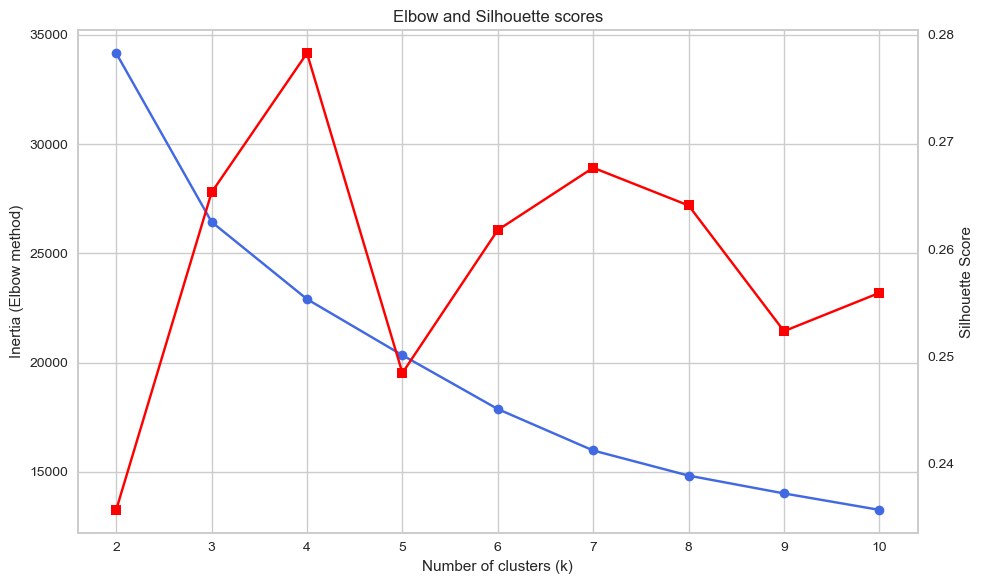

In [225]:
k_range = range(2, 11)
elbow_scores, silhouette_scores = [], []

for k in k_range:
    km = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    labels = km.fit_predict(pca_customer_df)
    elbow_scores.append(km.inertia_)
    silhouette_scores.append(silhouette_score(pca_customer_df, labels))

fig, ax1 = plt.subplots(figsize = (10, 6))

ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow method)')
ax1.plot(k_range, elbow_scores, color = "royalblue", marker = "o", label = 'Inertia (Elbow method)')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score')
ax2.plot(k_range, silhouette_scores, color = "red", marker = "s", label = 'Silhouette Score')

plt.title('Elbow and Silhouette scores')
fig.tight_layout()
plt.grid(axis = 'y')
plt.xticks(k_range)
plt.show()

The optimal number of clusters K identified using a combined approach of the Elbow method (Inertia) and Silhouette score is 3. Selecting K = 3 provides the most balanced solution, clearly separating customers into distinct groups while ensuring clusters remain compact and coherent.

This choice enhances the reliability and effectiveness of my customer segmentation, allowing us to implement tailored marketing strategies. By segmenting customers into three distinct groups, we gain actionable insights into customer behavior, preferences and spending habits, enabling the creation of targeted marketing campaigns that drive increased customer engagement, satisfaction and business profitability.

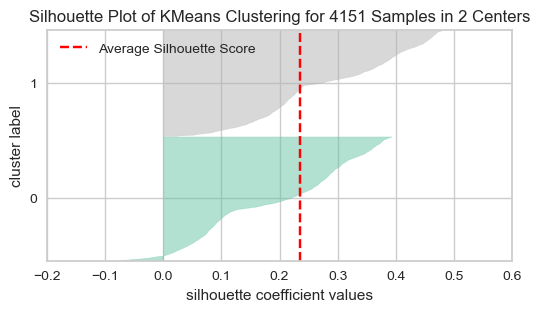

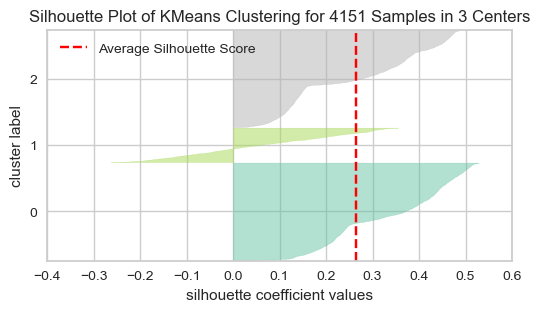

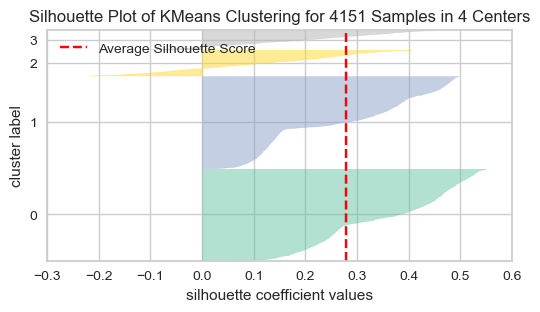

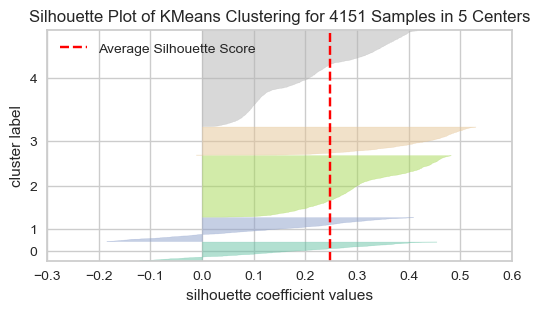

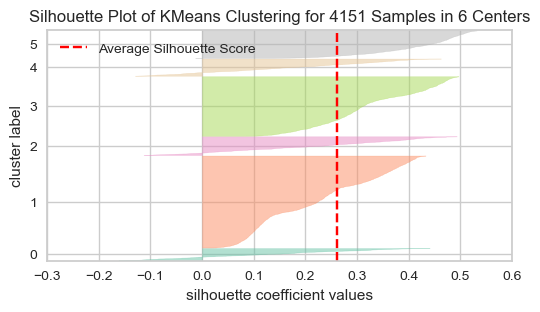

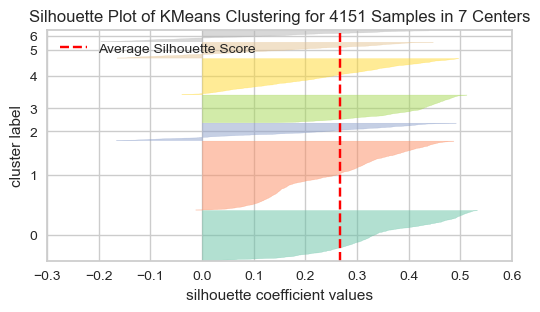

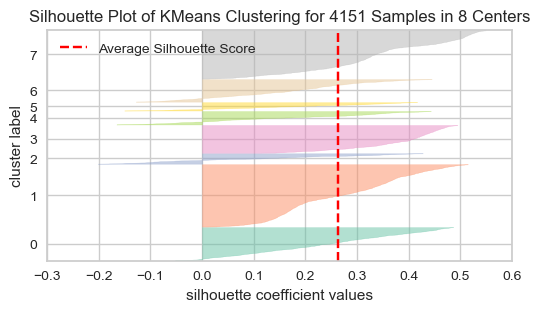

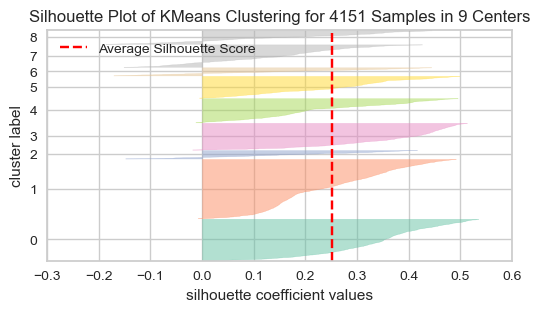

In [230]:
k_range = range(2, 10) 

for k in k_range:
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
    visualizer = SilhouetteVisualizer(kmeans, colors = 'Set2', size = (600, 300))
    
    visualizer.fit(pca_customer_df) 
    visualizer.show()  

### K-Means clustering model

In [232]:
# run K-Means with optimal K = 3:
k_means = KMeans(n_clusters = 3, max_iter = 100, n_init = 10, random_state = 42)
k_means.fit(pca_customer_df)

original_labels = k_means.labels_

In [233]:
# frequency of each cluster
cluster_frequencies = Counter(original_labels)

# mapping clusters by frequency (largest cluster = 0, second largest = 1...)
sorted_clusters = [label for label, _ in cluster_frequencies.most_common()]
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}

new_labels = np.array([label_mapping[label] for label in original_labels])
pca_customer_df["cluster"] = new_labels
clean_data["cluster"] = new_labels

In [234]:
clean_data.sample(5)

,count_unique_products,recency,frequency,monetary,average_transaction_value,is_from_uk,favorite_shopping_day,monthly_spending_mean,cancellation_frequency,cancellation_rate,cluster
customer_id,,,,,,,,,,,
15327.0,-0.740129,-0.401181,-0.688556,-0.634059,-0.358263,1,1,-0.545425,-0.423290,-0.449001,0
14457.0,-0.840052,2.172072,-0.688556,-0.698594,-0.806417,1,2,-0.901217,-0.423290,-0.449001,0
18269.0,-0.790090,2.640843,-0.467675,-0.681454,-1.014639,1,2,-0.806723,-0.064922,0.705186,0
15948.0,-0.057323,-0.850005,-0.467675,-0.127549,0.908641,1,3,0.460375,-0.423290,-0.449001,1
17600.0,-0.690168,-0.750266,-0.688556,-0.666004,-0.580102,1,1,-0.721544,-0.423290,-0.449001,0


In [235]:
cluster_counts = pd.DataFrame(clean_data.cluster.value_counts()).reset_index()
cluster_counts

,cluster,count
0,0,1771
1,1,1756
2,2,624


In [236]:
# calculate percentage of total records
cluster_counts["pct"] = (cluster_counts["count"] / cluster_counts["count"].sum()) * 100
cluster_counts

,cluster,count,pct
0,0,1771,42.664418
1,1,1756,42.303060
2,2,624,15.032522


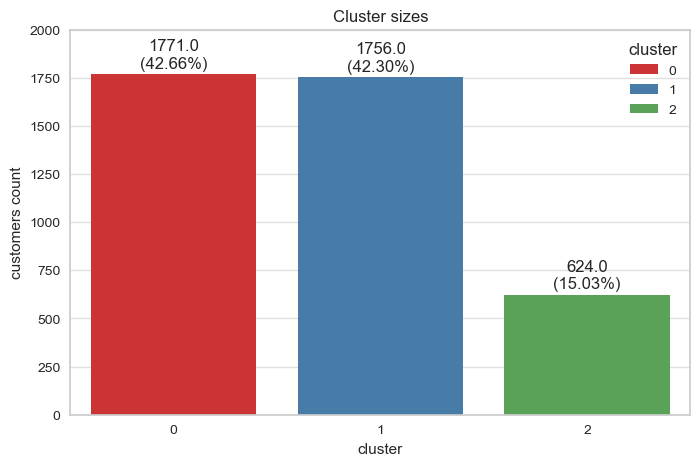

In [250]:
plt.figure(figsize = (8, 5))
barplot = sns.barplot(x = "cluster", y = "count", hue = "cluster", data = cluster_counts, palette = "Set1")

# add labels for counts and percentages on top of bars:
for index, row in cluster_counts.iterrows():
    barplot.text(index, row["count"] + 30, f'{row["count"]}\n({row["pct"]:.2f}%)', ha = "center")

plt.title("Cluster sizes")
plt.xlabel("cluster")
plt.ylabel("customers count")
plt.ylim(0, 2000)
plt.grid(axis = "y", alpha = 0.6)
plt.show()

## Clusters analysis

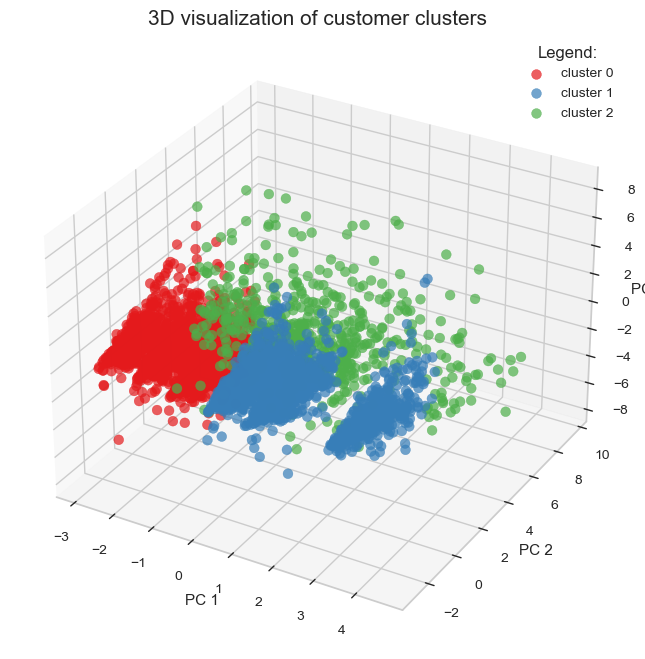

In [249]:
x = pca_customer_df["PC1"]
y = pca_customer_df["PC2"]
z = pca_customer_df["PC3"]
clusters = pca_customer_df["cluster"]

fig = plt.figure(figsize = (12, 8))
palette = sns.color_palette("Set1", n_colors = 3)
ax = fig.add_subplot(111, projection = "3d")

# plot each cluster separately to match colors exactly:
for cluster_label in sorted(pca_customer_df.cluster.unique()):
    idx = clusters == cluster_label
    ax.scatter(
        x[idx], y[idx], z[idx], 
        s = 50, alpha = 0.7, 
        label = f"cluster {cluster_label}", 
        color = palette[cluster_label],
    )

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D visualization of customer clusters", fontsize = 15)
ax.legend(title = "Legend:")
plt.show()

From the 3D visualisation we cans see that:
- Red cluster is clearly separate and compact - likely distinct customers.
- Blue cluster is has dense, overlapping region - possibly frequent or high-value shoppers.
- Green	cluster is spread out - maybe average or transitional customers between the two extremes.

So the next step os to profile each cluster:

## Profile each cluster 

In [255]:
features_to_profile = [
    'count_unique_products', 'recency', 'frequency', 'monetary',
    'average_transaction_value', 'monthly_spending_mean',
    'cancellation_frequency', 'cancellation_rate'
]

cluster_profiles = clean_data.groupby('cluster')[features_to_profile].mean().round(2)

cluster_sizes = clean_data['cluster'].value_counts().sort_index()
cluster_profiles['num_customers'] = cluster_sizes.values
cluster_profiles

,count_unique_products,recency,frequency,monetary,average_transaction_value,monthly_spending_mean,cancellation_frequency,cancellation_rate,num_customers
cluster,,,,,,,,,
0,-0.28,0.11,-0.28,-0.31,-0.09,-0.18,-0.22,-0.11,1771
1,-0.20,0.12,-0.29,-0.31,-0.11,-0.19,-0.24,-0.14,1756
2,1.37,-0.65,1.61,1.73,0.58,1.03,1.32,0.71,624


- Cluster 0 and 1 are similar. It has low frequency, low spending, lower engagement. Possibly low-value or occasional shoppers. The difference is in cancellation behavior.
- Cluster has very high frequency, monetary value and monthly spend. Also higher cancellation behavior. Likely high-value but demanding customers.

### Spider / Radar plot 
For visualizing feature differences between clusters.

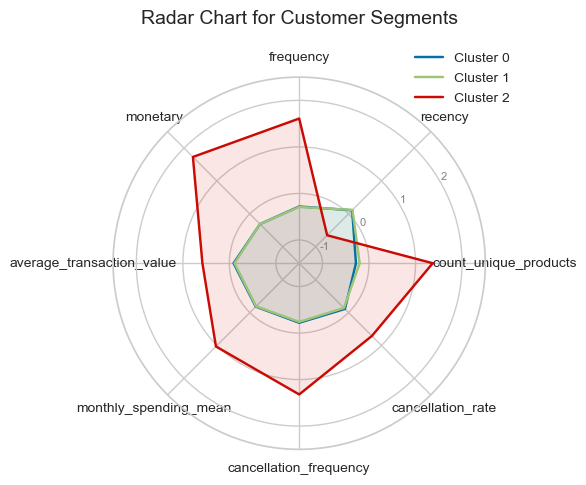

In [262]:
radar_data = cluster_profiles.drop(columns=["num_customers"])
features = radar_data.columns.tolist()
num_vars = len(features)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for idx, row in radar_data.iterrows():
    values = row.tolist()
    values += values[:1] 
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=10)
ax.set_rlabel_position(30)
plt.yticks([-1, 0, 1, 2], ['-1', '0', '1', '2'], color='gray', size=8)
plt.ylim(-1.5, 2.5)
plt.title("Radar Chart for Customer Segments", size=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

### Conclusion
Each axis represents one customer behavior feature and the further from the center, the higher the value for that cluster on that feature. 

- Cluster 0 (blue) indicates low-value customers. Lowest across almost all axes (features). Likely inactive or churned customers who rarely buy and don't spend much.

- Cluster 1 (green) shows Low Engagement (value). All features are around or slightly below average. Slightly better than Cluster 0 in recency. Possibly newer or occasional shoppers with low engagement.

- Cluster 2 (red) represents high-value customers. Very high frequency (they buy often), monetary (they spend a lot) and count_unique_products (diverse buying habits). High monthly_spending_mean - consistent high spending. Also high cancellation features because they cancel more, but are very active. Recency is low because they purchased recently. 

**Recommendation** \
🔵 0 Churned or cold - win-back campaigns, targeted reactivation offers. \
🟢 1 Occasional buyers - education campaigns, upsell or engagement content. \
🔴 2 VIP customers loyalty rewards, premium offers, re-engagement if they cancel.